<font color='red'>**Auswertung des Auflade- und Entladevorgangs eines Kondensators mit dem Analog-Digitalwandler ADS1115 und Messwerterfassungssystem DMSRP** </font>

<font color='red'>Ziele:</font>


1.   Das auf dem Raspberry Pi basierte digitale Messwerterfassungssystem DMSRP ermöglicht die Speicherung der Spannung am Kondensator während des Lade- und Entladevorgangs. Mit Pandas werden die Messdaten aus dem .csv File ausgelesen und mit Matplotlib grafisch dargestellt.

2.   Da für die Bestimmung der Zeitkonstante der RC-Schaltung nur das Entladen des Kondesators verwendet wird, sucht man nach eine Möglichkeit, die Maximal- und Minimalwerte in den gespeichrten Messdaten zu ermitteln.

3. Die gefundenen Werte der Zeit und Spanung U_C(t) werden logarithmiert, und die Regressinsgerade durch die ln(U_C(t)) ermittelt. Daraus wird die Zeitkonstante bestimmt.

4. Ausgehend von der Zeitkonstante kann man die Wirkung des Widerstandes und der Kapazität des Kondesnators diskutieren.


# Spannung am Kondesator $U_C(t)$ während des Entladens
$$
U_C(t)=|U_0| \cdot e^{-\frac{t}{RC}}
$$

$$
\ln(U_C(t))=\ln(|U_0| \cdot e^{-\frac{t}{RC}})=-\frac{1}{RC} \cdot t + \ln(|U_0|)
$$

In [7]:
%%capture 
%pip install matplotlib pandas scikit-learn 

In [8]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

In [9]:
# Import data from CSV
df = pd.read_csv("testfile_210325-1403_C=10mikro.csv", skiprows=2, delimiter=";")
df

,U_GPIO/V,U_C/V,t/s
0,3.29000,3.28700,0.0
1,3.29100,3.28700,0.1
2,3.29100,3.28700,0.2
3,3.29100,3.28700,0.3
4,3.29000,3.28700,0.4
...,...,...,...
284,-0.01213,0.12700,28.4
285,-0.01288,0.11730,28.5
286,-0.01250,0.10890,28.6
287,-0.01263,0.10010,28.7


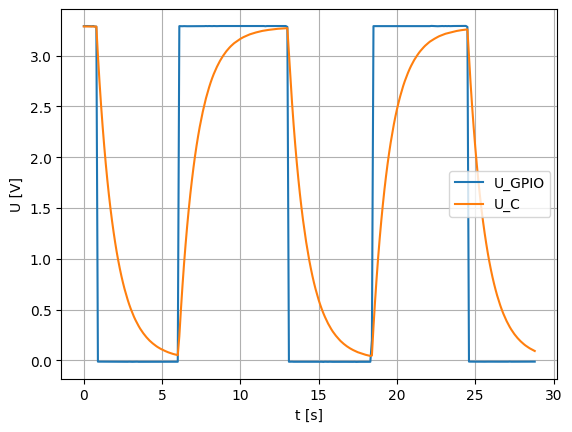

In [10]:
# Plot data
plt.plot(df["t/s"], df["U_GPIO/V"], label="U_GPIO")
plt.plot(df["t/s"], df["U_C/V"], label="U_C")
plt.xlabel("t [s]")
plt.ylabel("U [V]")
plt.grid()
plt.legend()
plt.show()

Charge at t=6.0 (index=60)
Charge at t=18.4 (index=184)
Discharge at t=0.8 (index=8)
Discharge at t=13.0 (index=130)
Discharge at t=24.5 (index=245)


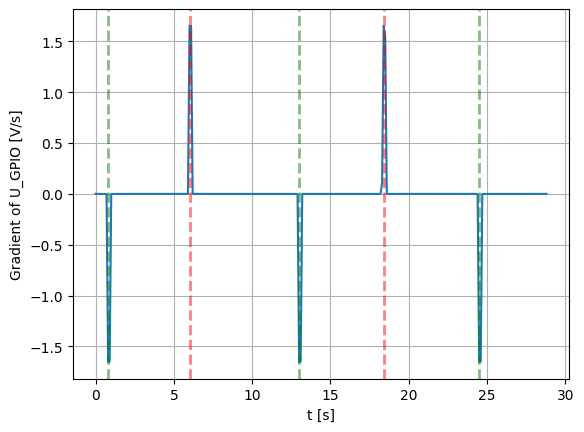

In [11]:
# Plot gradient of U_GPIO and charges/discharges of capacitor
grad_gpio = np.gradient(df["U_GPIO/V"])
charges = find_peaks(grad_gpio, height=1)[0]
discharges = find_peaks(-grad_gpio, height=1)[0]
plt.plot(df["t/s"], grad_gpio)

for charge in charges:
    print(f"Charge at t={df['t/s'][charge]} (index={charge})")
    plt.axvline(x=df["t/s"][charge], color="r", linestyle="--", linewidth=2, alpha=0.5)

for discharge in discharges:
    print(f"Discharge at t={df['t/s'][discharge]} (index={discharge})")
    plt.axvline(x=df["t/s"][discharge], color="g", linestyle="--", linewidth=2, alpha=0.5)


plt.xlabel("t [s]")
plt.ylabel("Gradient of U_GPIO [V/s]")
plt.grid()
plt.show()

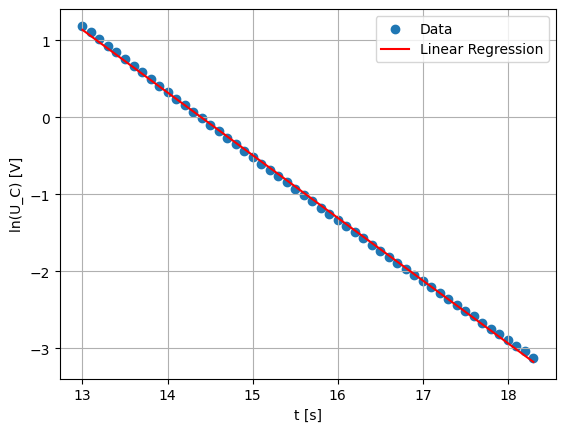

-1/RC=-0.8137012520193617
RC=1.2289522690524328


In [12]:
# Plot using logarithmic scale

# Start & end index from cell before
i_start = 130
i_end = 184

u = df["U_C/V"][i_start:i_end]
t = df["t/s"][i_start:i_end]

log_u = np.log(u)

regr = LinearRegression()
regr.fit(np.array(t).reshape(-1, 1), log_u)
u_pred = regr.predict(np.array(t).reshape(-1, 1))

plt.scatter(t, log_u, label="Data")
plt.plot(t, u_pred, color="r", label="Linear Regression")
plt.xlabel("t [s]")
plt.ylabel("ln(U_C) [V]")
plt.grid()
plt.legend()
plt.show()

k = regr.coef_[0]
print(f"-1/RC={k}")
print(f"RC={-1/k}")